# Importing required libraries

In [1]:
from dateutil.parser import parse 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import scipy.stats as sp

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

#plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Importing the dataset

In [2]:
# Fetching the data
data = pd.read_csv('Coal Power.csv')
data.head()

,Unnamed: 0,Total consumption : Texas : electric power (total) : quarterly (short tons)
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


# EDA and Preprocessing the Data

In [3]:
# Changing column names
data.columns = ['Year_Quarter','Consumptions']
data['Year_Quarter'] = data['Year_Quarter'].str.strip()
data['Year_Quarter'] = data['Year_Quarter'].str.replace(' ','-')
data.tail()
# Data is from Jan 1990 to Dec 2022
# We have 33 years data

,Year_Quarter,Consumptions
75,2019-Q4,13866538
76,2020-Q1,11029285
77,2020-Q2,12950538
78,2020-Q3,17219614
79,2020-Q4,14869537


In [4]:
# Checking data types of the columns as date format is different
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year_Quarter  80 non-null     object
 1   Consumptions  80 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [39]:
data.describe()

,Consumptions,year
count,8.000000e+01,80.000000
mean,2.330880e+07,2010.500000
std,4.137809e+06,5.802662
min,1.102928e+07,2001.000000
25%,2.186000e+07,2005.750000
50%,2.413629e+07,2010.500000
75%,2.534612e+07,2015.250000
max,3.187314e+07,2020.000000


In [5]:
qs = data['Year_Quarter'].str.replace(r'(Q\d) (\d+)', r'\2 \1')
qs

<ipython-input-5-42389f47afb7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qs = data['Year_Quarter'].str.replace(r'(Q\d) (\d+)', r'\2 \1')


0     2001-Q1
1     2001-Q2
2     2001-Q3
3     2001-Q4
4     2002-Q1
       ...   
75    2019-Q4
76    2020-Q1
77    2020-Q2
78    2020-Q3
79    2020-Q4
Name: Year_Quarter, Length: 80, dtype: object

In [6]:
data['Date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data

,Year_Quarter,Consumptions,Date
0,2001-Q1,22164839,2001-01-01
1,2001-Q2,22952510,2001-04-01
2,2001-Q3,25962808,2001-07-01
3,2001-Q4,21357650,2001-10-01
4,2002-Q1,21917084,2002-01-01
...,...,...,...
75,2019-Q4,13866538,2019-10-01
76,2020-Q1,11029285,2020-01-01
77,2020-Q2,12950538,2020-04-01
78,2020-Q3,17219614,2020-07-01


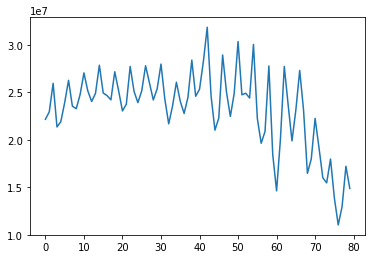

In [7]:
plt.plot(data['Consumptions'])

In [8]:
# Smoothning the Data
#data['Price'] = data['Price'].ewm(span=15).mean()

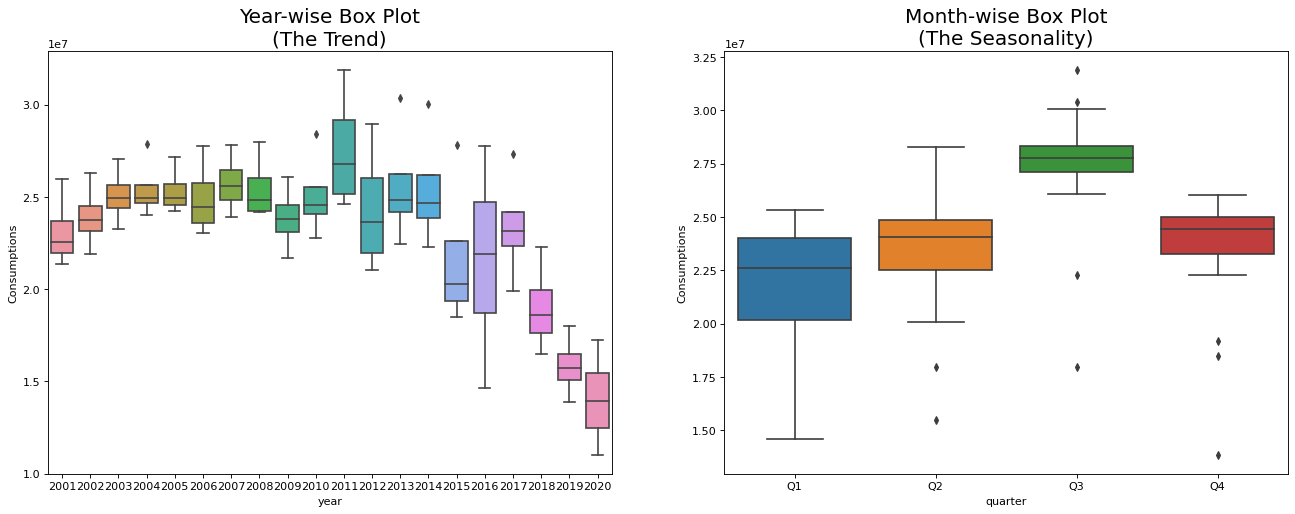

In [9]:
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# Prepare data

df = data
df['year'] = [d.year for d in data.Date]
df['quarter'] = [d[-2:] for d in data.Year_Quarter]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Consumptions', data=df, ax=axes[0])
sns.boxplot(x='quarter', y='Consumptions', data=df.loc[~df.year.isin([2001, 2020]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# There seems to be a trend the data but no seasonality

# Splitting the Data into train and test

In [10]:
train = data.iloc[:int(0.7*len(data))-1,:]
test = data.iloc[int(0.7*len(data))-1:,:]

In [11]:
train

,Year_Quarter,Consumptions,Date,year,quarter
0,2001-Q1,22164839,2001-01-01,2001,Q1
1,2001-Q2,22952510,2001-04-01,2001,Q2
2,2001-Q3,25962808,2001-07-01,2001,Q3
3,2001-Q4,21357650,2001-10-01,2001,Q4
4,2002-Q1,21917084,2002-01-01,2002,Q1
5,2002-Q2,23929655,2002-04-01,2002,Q2
6,2002-Q3,26277274,2002-07-01,2002,Q3
7,2002-Q4,23548673,2002-10-01,2002,Q4
8,2003-Q1,23284033,2003-01-01,2003,Q1
9,2003-Q2,24767874,2003-04-01,2003,Q2


In [12]:
test

,Year_Quarter,Consumptions,Date,year,quarter
55,2014-Q4,22272614,2014-10-01,2014,Q4
56,2015-Q1,19639959,2015-01-01,2015,Q1
57,2015-Q2,20880065,2015-04-01,2015,Q2
58,2015-Q3,27792799,2015-07-01,2015,Q3
59,2015-Q4,18466374,2015-10-01,2015,Q4
60,2016-Q1,14616943,2016-01-01,2016,Q1
61,2016-Q2,20077346,2016-04-01,2016,Q2
62,2016-Q3,27738163,2016-07-01,2016,Q3
63,2016-Q4,23698040,2016-10-01,2016,Q4
64,2017-Q1,19887551,2017-01-01,2017,Q1


# Checking the trend and seasonal decompose of the train data

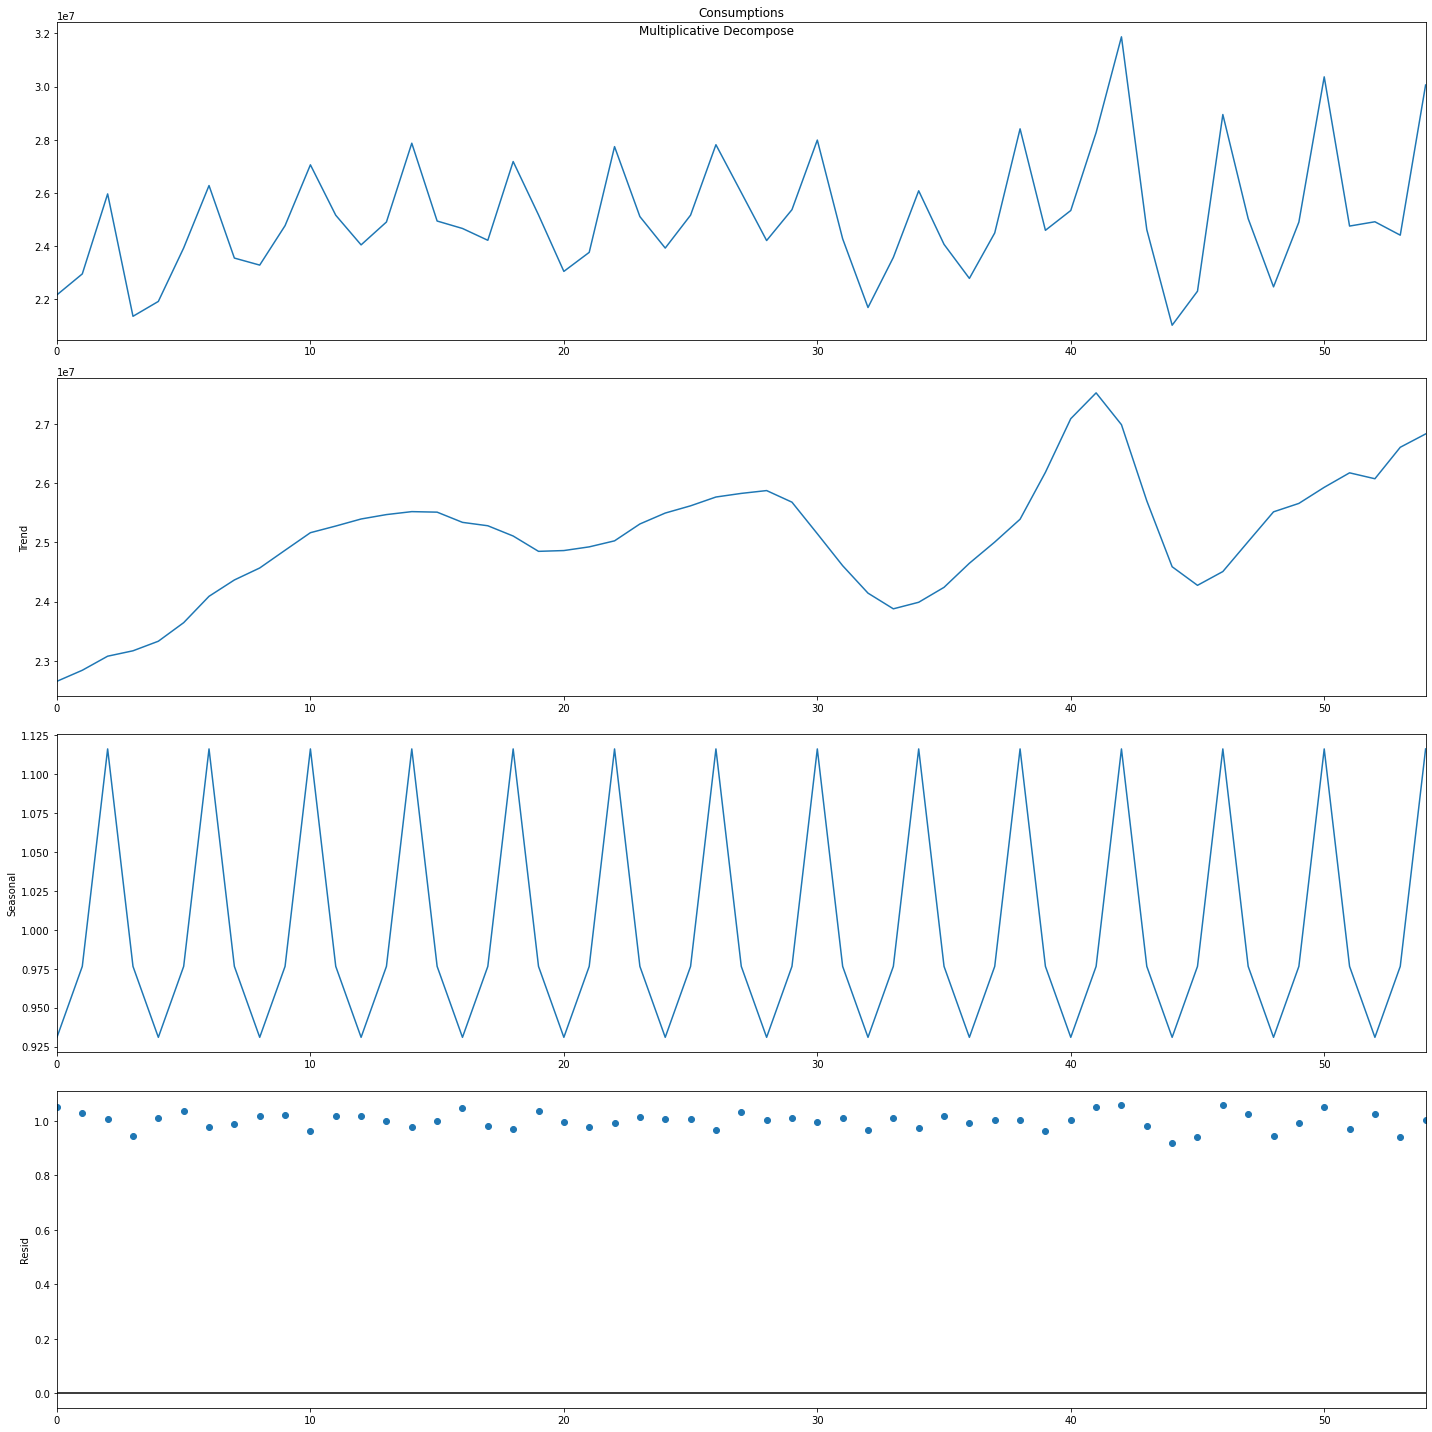

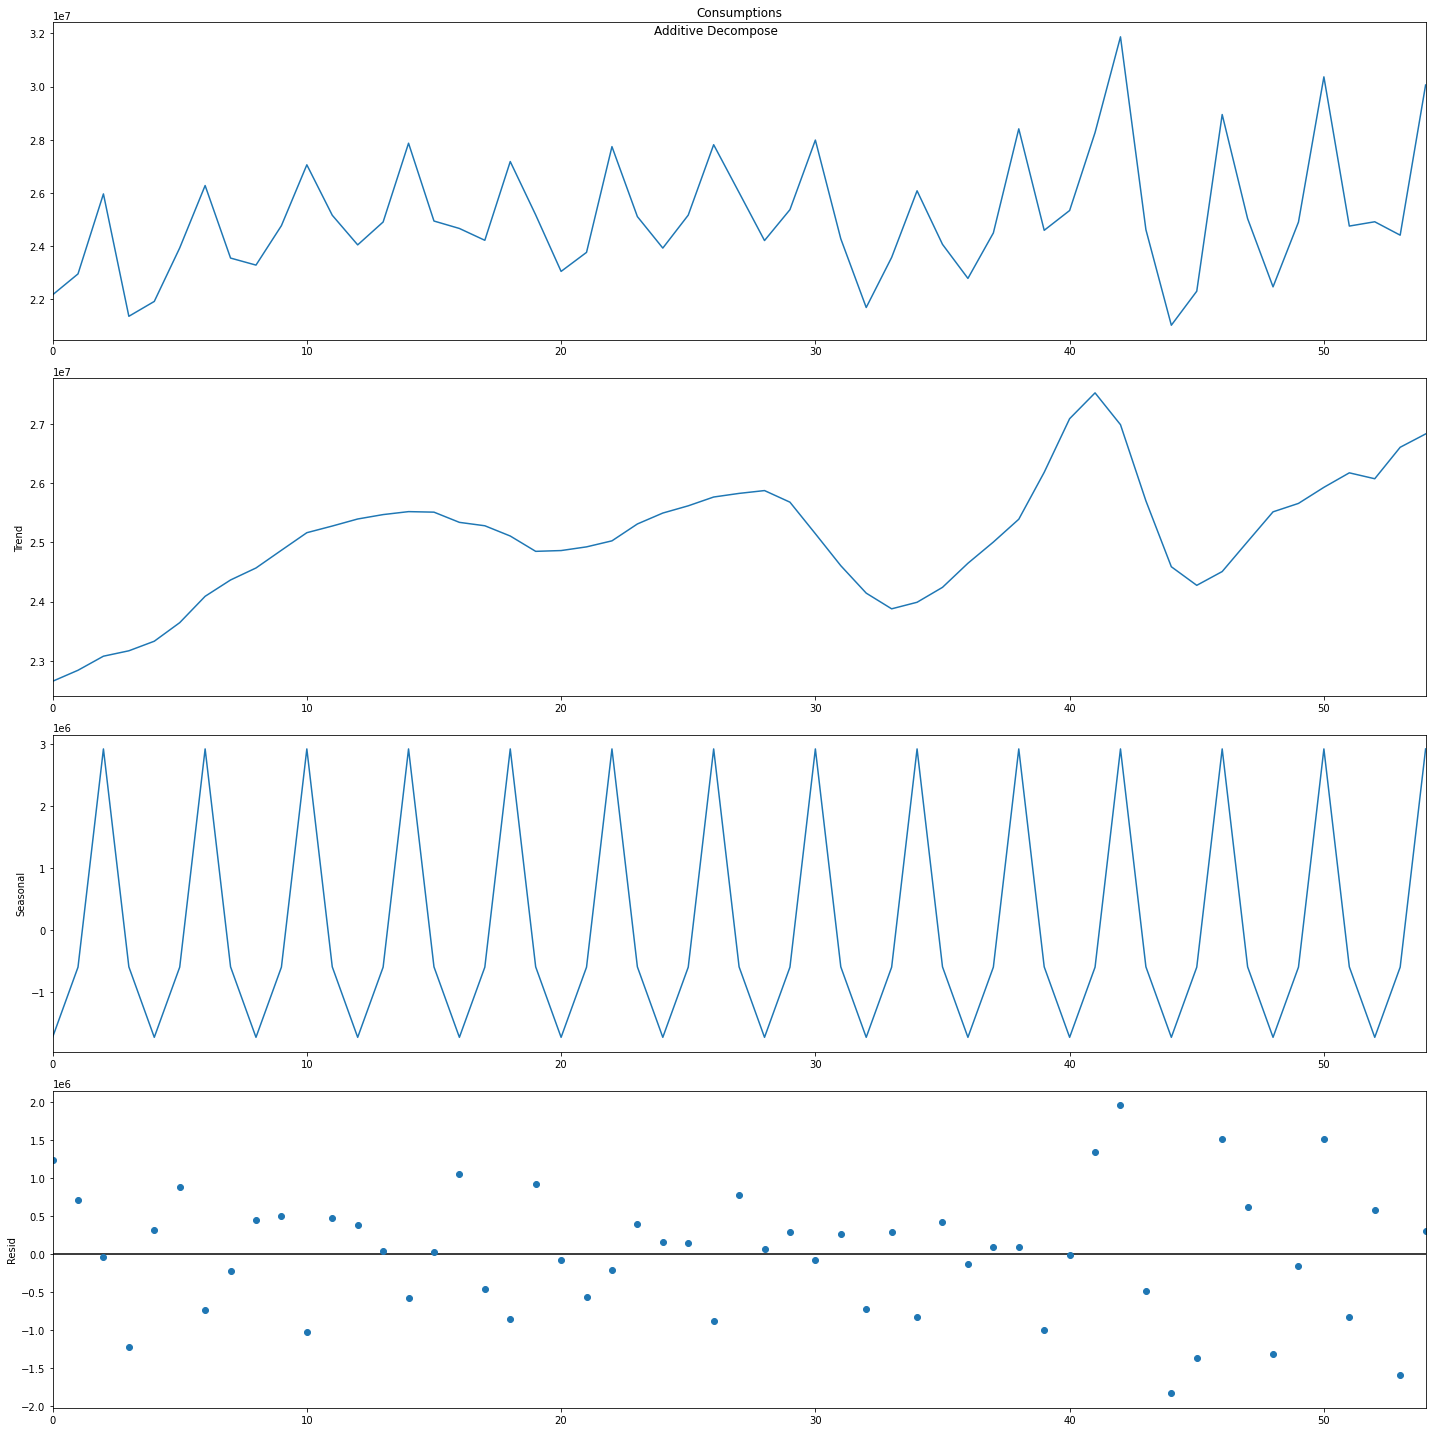

In [13]:
# Additive and multiplicative time series
# Decomposing data into additive and multiplicative components

# Multiplicative Decomposition 
result_mul = seasonal_decompose(train['Consumptions'], period = 4, model='multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(train['Consumptions'], period = 4, model='additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (20,20)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

# Since the residuals are random in the additive decompose, we can say that the data
# follows an additive decompose and contains both a quaterly seasonal and trend element

In [14]:
# Additive components
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed['addition'] = df_reconstructed['seas']+df_reconstructed['trend']+df_reconstructed['resid']
df_reconstructed.head()

,seas,trend,resid,actual_values,addition
0,-1.732471e+06,2.265528e+07,1.242035e+06,22164839.0,22164839.0
1,-5.992456e+05,2.284116e+07,7.105920e+05,22952510.0,22952510.0
2,2.925693e+06,2.307848e+07,-4.136779e+04,25962808.0,25962808.0
3,-5.939764e+05,2.316966e+07,-1.218030e+06,21357650.0,21357650.0
4,-1.732471e+06,2.333111e+07,3.184479e+05,21917084.0,21917084.0


# ADF and KPSS Test

In [15]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(train.Consumptions.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence accept null hypothesis, data is stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(train.Consumptions.values, regression='ct') 
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence reject null hypothesis, data is stationary

ADF Statistic: -3.202601762902976
p-value: 0.01983457204319564
Critial Values:
   1%, -3.5885733964124715
Critial Values:
   5%, -2.929885661157025
Critial Values:
   10%, -2.6031845661157025

KPSS Statistic: 0.129005
p-value: 0.081472
Critial Values:
   10%, 0.119
Critial Values:
   5%, 0.146
Critial Values:
   2.5%, 0.176
Critial Values:
   1%, 0.216


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


# De-trending the data

**Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.**  
  
- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.  
- Subtract the trend component obtained from time series decomposition we saw earlier.  
  
- Subtract the mean  
  
- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

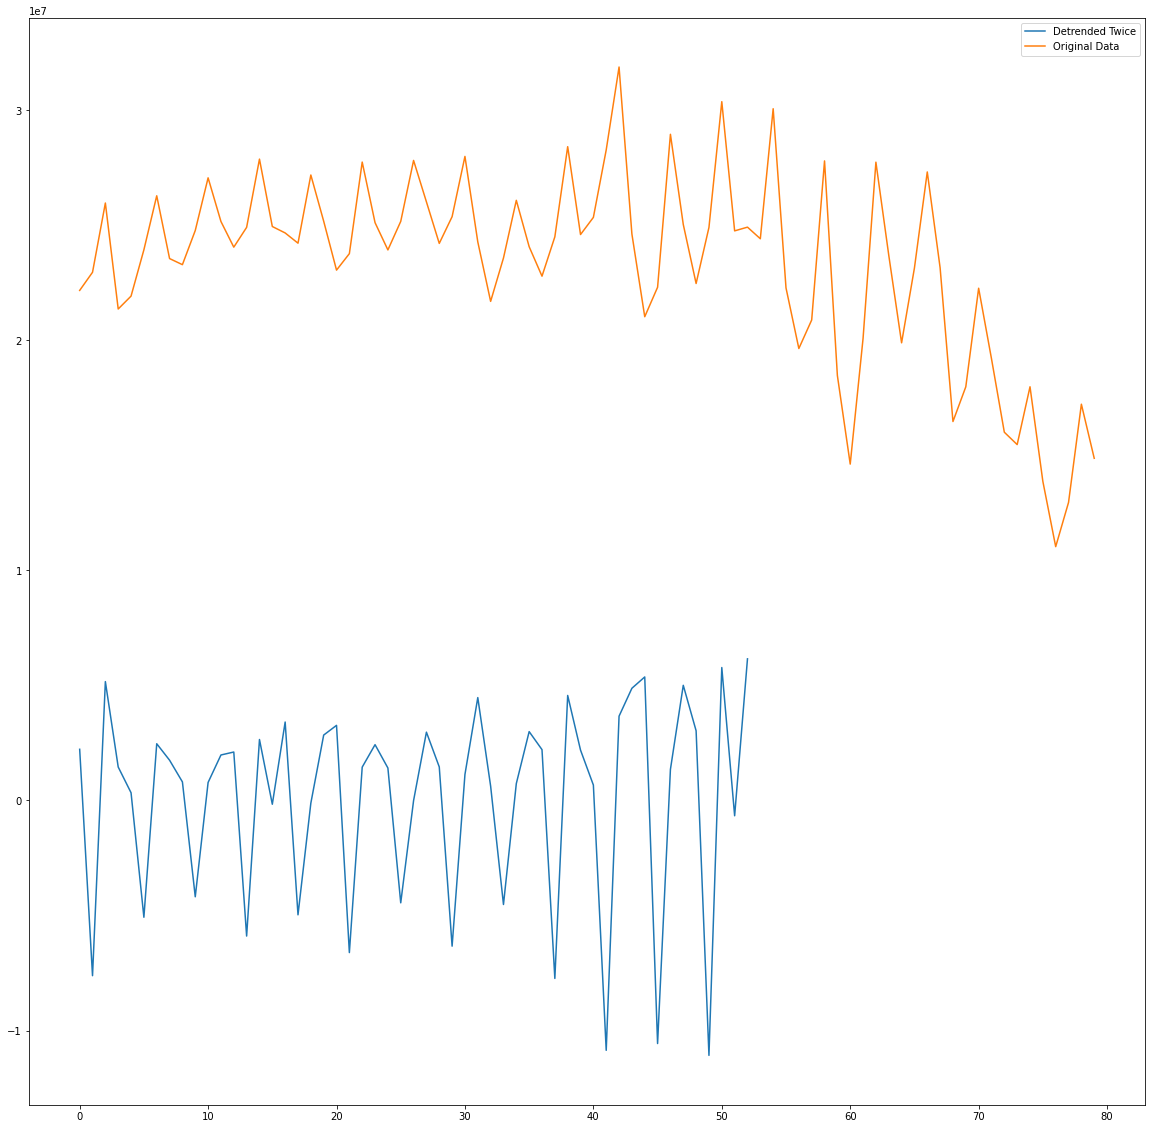

In [16]:
# Given data follows a stochastic trend that is increase and decrease in values does not follow a consistent pattern

# Detrending using difference method
#create a differenced series
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval,len(dataset)):
        value=dataset[i]-dataset[i-interval]
        diff.append(value)
    return (diff)

df_detrend=difference(train['Consumptions'])
df_detrend2=difference(df_detrend)

plt.plot(df_detrend2,label = 'Detrended Twice')
plt.plot(data.Consumptions.values,label='Original Data')
#plt.plot(pd.DataFrame(df_detrend.values).ewm(span=15).mean(),label='EWM')
plt.legend()

In [17]:
# Testing for stationarity on detrended data
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(df_detrend2, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence accept null hypothesis, data is stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(df_detrend2, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence reject null hypothesis, data is stationary

ADF Statistic: -4.946093099515537
p-value: 2.834240274074178e-05
Critial Values:
   1%, -3.596635636000432
Critial Values:
   5%, -2.933297331821618
Critial Values:
   10%, -2.6049909750566895

KPSS Statistic: 0.303583
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


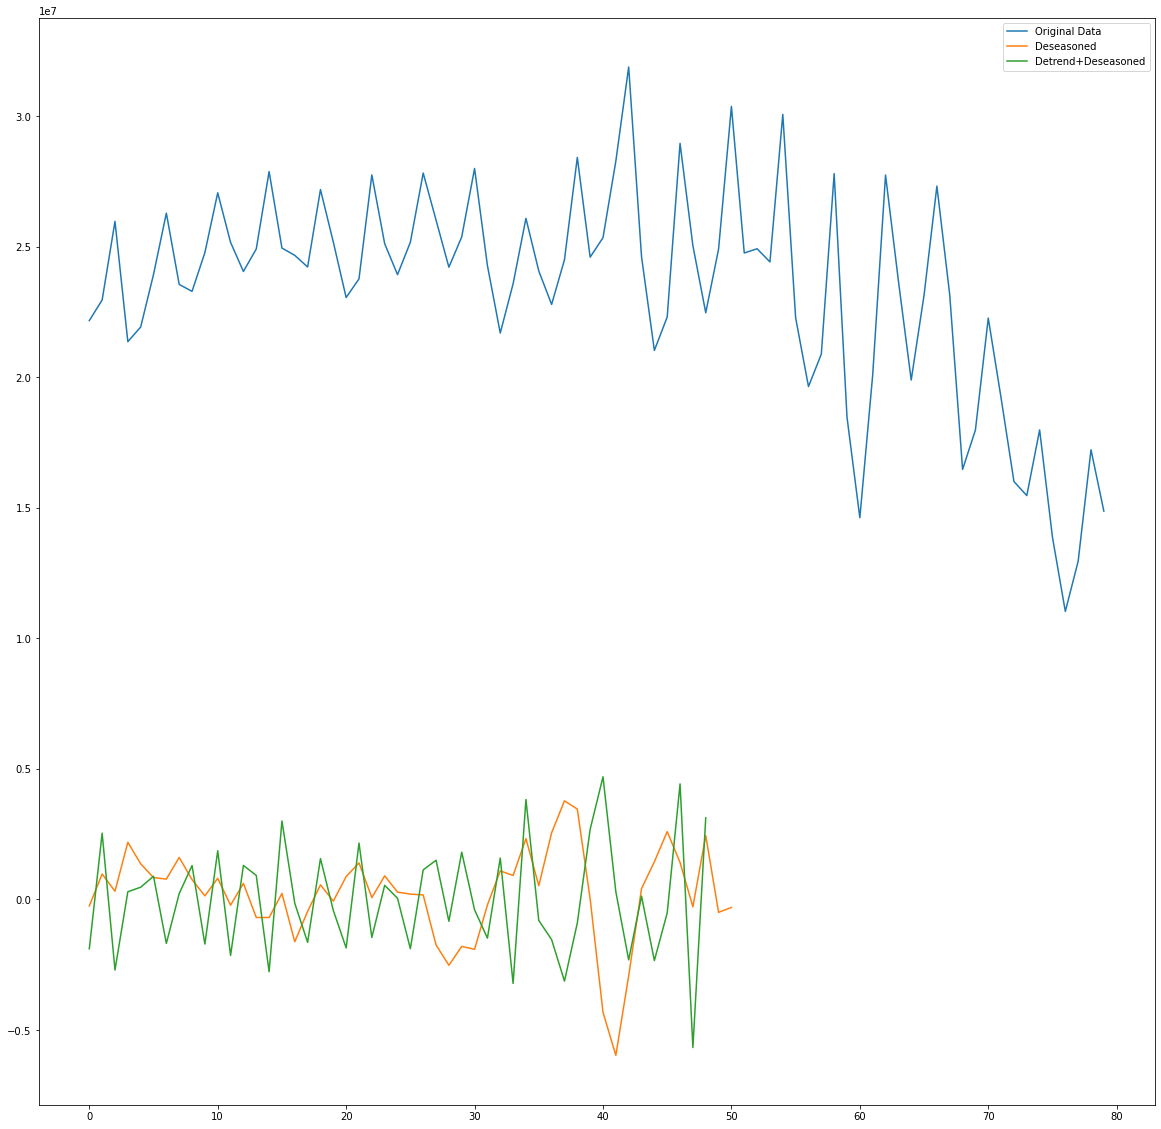

In [18]:
# De-seasonalize the data

df_final=difference(df_detrend2,4)
df_deseasoned=difference(train['Consumptions'],4)

plt.plot(data.Consumptions.values,label='Original Data')
plt.plot(df_deseasoned, label = 'Deseasoned')
plt.plot(df_final, label = 'Detrend+Deseasoned')
plt.legend()

In [19]:
# Testing for stationarity on detrended data
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(df_final, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence accept null hypothesis, data is stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(df_final, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence reject null hypothesis, data is stationary

ADF Statistic: -5.366839110706699
p-value: 3.974963593211293e-06
Critial Values:
   1%, -3.6155091011809297
Critial Values:
   5%, -2.941262357486514
Critial Values:
   10%, -2.6091995013850418

KPSS Statistic: 0.155249
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# ACF and PACF Plots

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


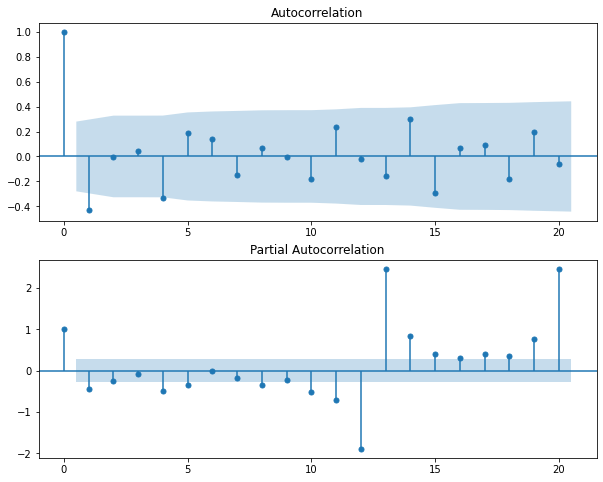

In [20]:
fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df_final,lags=20,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df_final,lags=20,ax=ax2)

# ACF is gradual and PACF is sudden. Hence it is AR(p) model with p = 1 from PACF plot

# Auto ARIMA

In [21]:
import pmdarima as pm

In [22]:
myfit = pm.auto_arima(train['Consumptions'], m=4,seasonal=True,trace=True, start_p = 0, start_q = 0, d=2,D=1,
                      error_action='ignore', # don't want to know if an order does not work
                      suppress_warnings=True, # don't want convergence warnings
                      stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[4]             : AIC=1572.513, Time=0.18 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=1570.116, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=1567.145, Time=0.07 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=1546.940, Time=0.12 sec
 ARIMA(0,2,1)(0,1,0)[4]             : AIC=1545.793, Time=0.04 sec
 ARIMA(0,2,1)(1,1,0)[4]             : AIC=1547.069, Time=0.11 sec
 ARIMA(0,2,1)(1,1,1)[4]             : AIC=1548.891, Time=0.31 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=1547.676, Time=0.10 sec
 ARIMA(0,2,2)(0,1,0)[4]             : AIC=1547.697, Time=0.10 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=1565.827, Time=0.04 sec
 ARIMA(1,2,2)(0,1,0)[4]             : AIC=1549.667, Time=0.16 sec
 ARIMA(0,2,1)(0,1,0)[4] intercept   : AIC=1548.944, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,1,0)[4]          
Total fit time: 1.312 seconds


# ARIMA

In [23]:
# Using parameters from Auto ARIMA
model=sm.tsa.arima.ARIMA(train['Consumptions'],order=(0,2,1),seasonal_order = (0,1,0,4))
# Using parameters from ACF and PACF 
#model=sm.tsa.arima.ARIMA(train['Consumptions'],order=(0,2,1),seasonal_order = (0,1,0,4))

model_res=model.fit()

print(model_res.summary())

                                    SARIMAX Results                                     
Dep. Variable:                     Consumptions   No. Observations:                   55
Model:             ARIMA(0, 2, 1)x(0, 1, [], 4)   Log Likelihood                -770.897
Date:                          Wed, 04 May 2022   AIC                           1545.793
Time:                                  12:36:27   BIC                           1549.577
Sample:                                       0   HQIC                          1547.229
                                           - 55                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9811      0.183     -5.356      0.000      -1.340      -0.622
sigma2      3.627e+12   2.31e-14   1.57e+26      0.

In [24]:
tspredict= model_res.predict(20)

tsforecast=model_res.forecast(25)

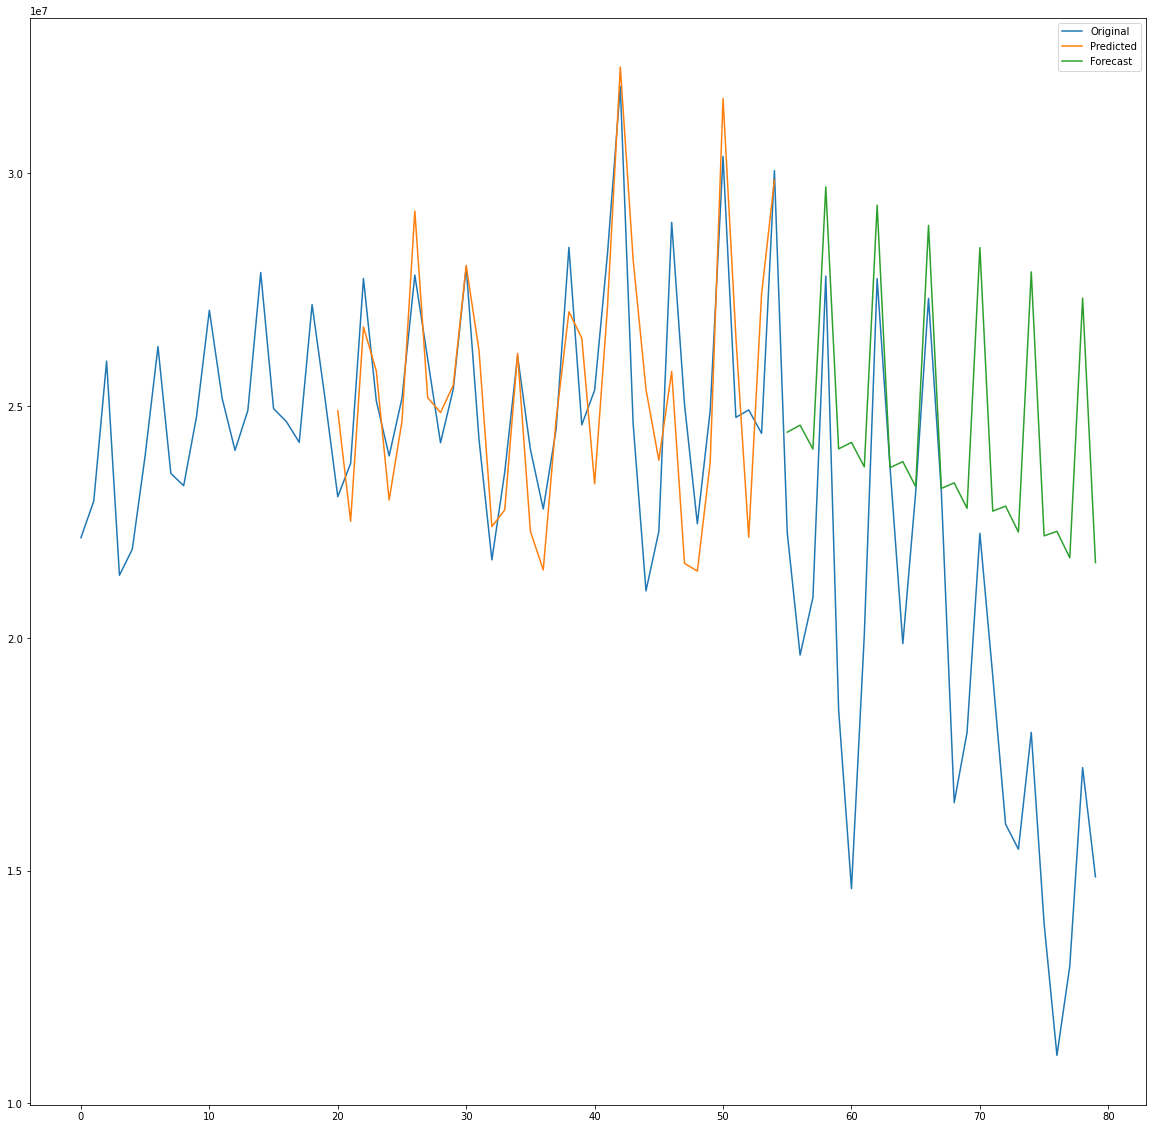

In [25]:
plt.plot(data['Consumptions'], label='Original')
plt.plot(tspredict, label='Predicted')
plt.plot(tsforecast, label='Forecast')
plt.legend()

In [26]:
rmse = mean_squared_error(test['Consumptions'], model_res.forecast(25), squared=False)
rmse

6111548.704981971

# Holt

In [27]:
from statsmodels.tsa.holtwinters import Holt

In [28]:
model = Holt(train['Consumptions'], exponential=True, damped_trend = True)

result = model.fit()

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [29]:
result.params

{'smoothing_level': 0.19357142857142856,
 'smoothing_trend': 0.19357142857142856,
 'smoothing_seasonal': nan,
 'damping_trend': 0.99,
 'initial_level': 22164839.0,
 'initial_trend': 1.0456317300860143,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [30]:
print(result.summary())

                               Holt Model Results                              
Dep. Variable:           Consumptions   No. Observations:                    55
Model:                           Holt   SSE                 351893029493815.812
Optimized:                       True   AIC                            1631.786
Trend:                 Multiplicative   BIC                            1641.823
Seasonal:                        None   AICC                           1634.169
Seasonal Periods:                None   Date:                  Wed, 04 May 2022
Box-Cox:                        False   Time:                          12:36:28
Box-Cox Coeff.:                  None                                          
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1935714                alpha                 True
smoothing_trend            0.1935714       

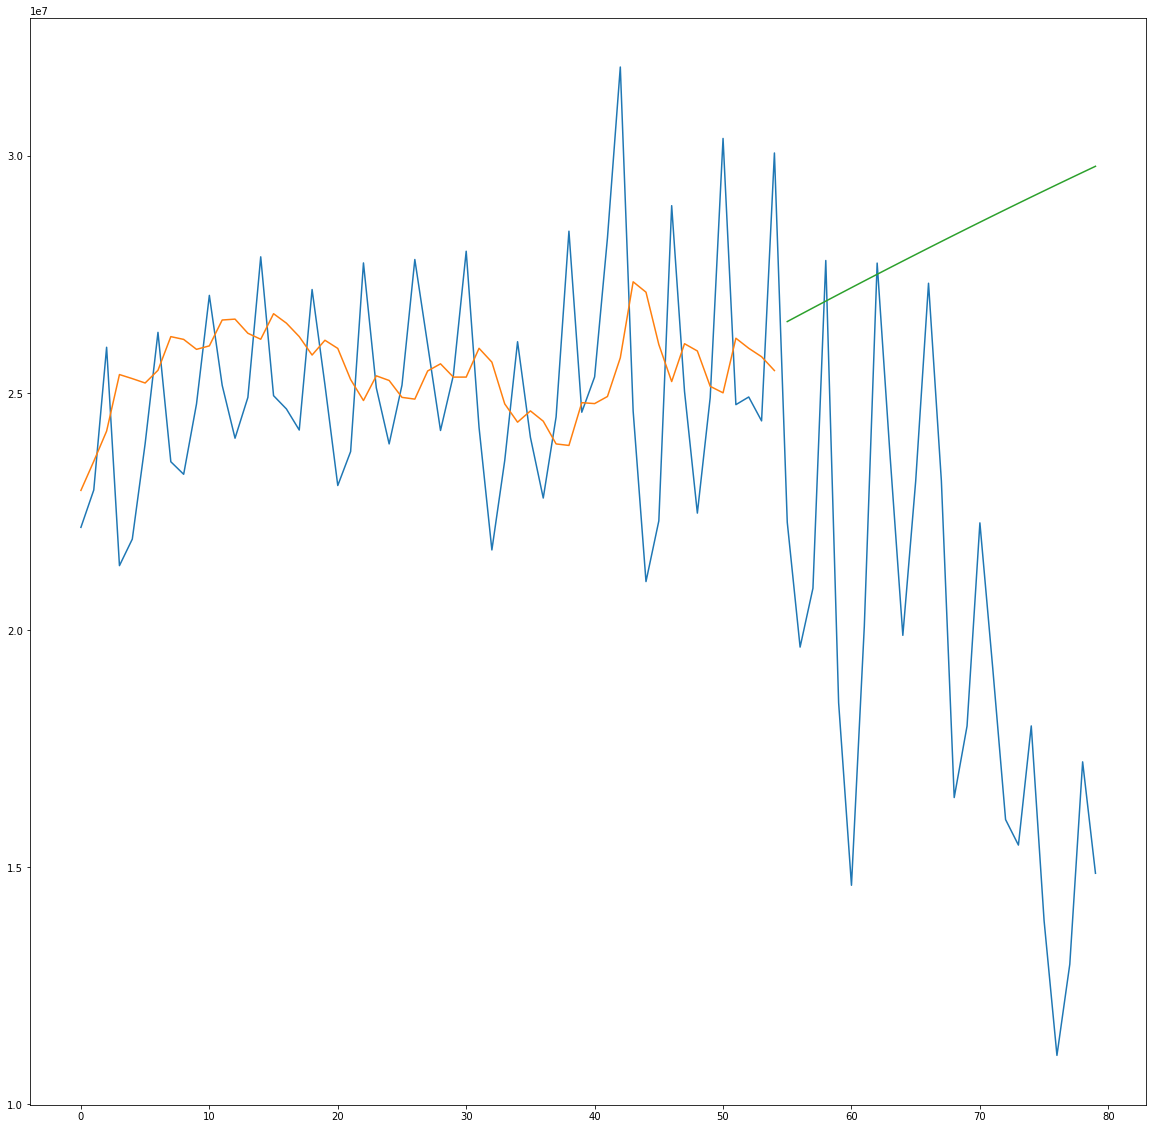

In [31]:
plt.plot(data['Consumptions'])
plt.plot(result.fittedvalues)
plt.plot(result.forecast(25))

In [32]:
rmse = mean_squared_error(test['Consumptions'], result.forecast(25), squared=False)
rmse

10190836.200034251

# Exponential Smoothing

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [34]:
model = ExponentialSmoothing(train['Consumptions'], trend='additive', seasonal='additive', seasonal_periods=4, damped_trend = True)

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
result3 = model.fit()
result3.params

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.5707142857142857,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.22593984962406014,
 'damping_trend': 0.99,
 'initial_level': 23247488.214285713,
 'initial_trend': 202179.9375,
 'initial_seasons': array([-1082649.21428571,  -294978.21428571,  2715319.78571429,
        -1889838.21428571]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [36]:
print(result3.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             Consumptions   No. Observations:                   55
Model:             ExponentialSmoothing   SSE                 94302215603927.625
Optimized:                         True   AIC                           1567.361
Trend:                         Additive   BIC                           1585.427
Seasonal:                      Additive   AICC                          1573.500
Seasonal Periods:                     4   Date:                 Wed, 04 May 2022
Box-Cox:                          False   Time:                         12:36:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5707143                alpha                 True
smoothing_trend          

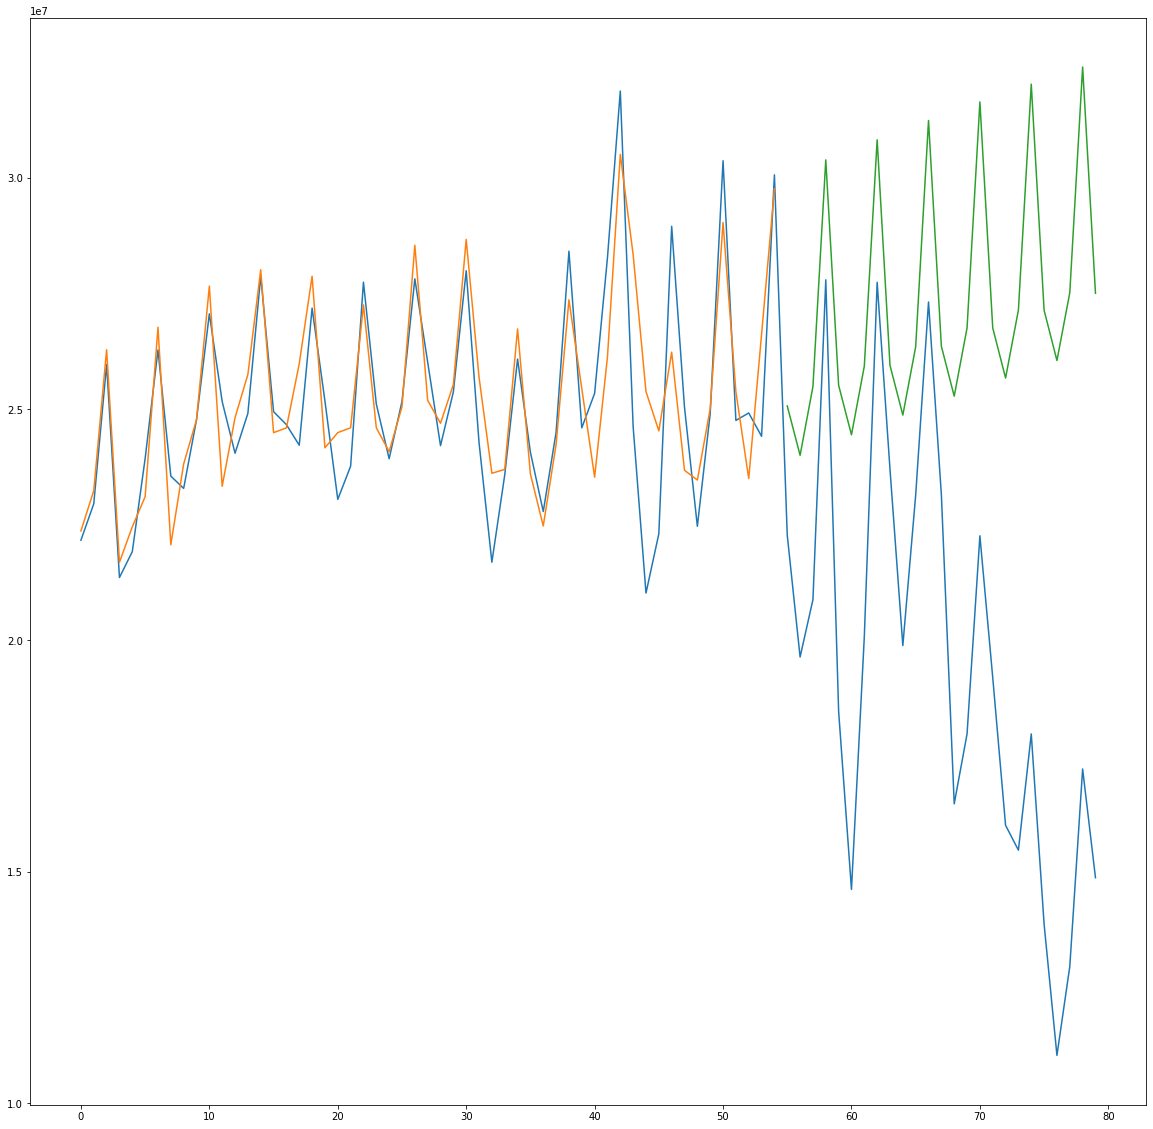

In [37]:
plt.plot(data['Consumptions'])
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(25))

In [38]:
rmse = mean_squared_error(test['Consumptions'], result3.forecast(25), squared=False)
rmse

9034610.355124788